In [5]:
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sbn
import os


In [6]:
root = '/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_predictions/complex2' 

data_path = '/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_predictions/complex2/Data.pt' 
targ_path = '/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_predictions/complex2/targetome__drug_targets_gene.csv' 

In [7]:
data = torch.load(data_path, weights_only=False) 

In [62]:
for node_type, names in data.node_name_dict.items(): 
    print(node_type, '->', len(names)) 


disease -> 6755
drug -> 2893
gene -> 16879
pathway -> 2363


In [63]:
len(data.edge_index_dict.keys())

31

In [61]:
total_edges = 0
for key, ei in data.edge_index_dict.items(): 
    print(key, '->', ei.shape[1])
    total_edges += ei.shape[1]
print(f'Total edges: {total_edges}')


('gene', 'VCAP_lincs_perturbation_rev', 'drug') -> 1284
('gene', 'stimulates_rev', 'gene') -> 64030
('gene', 'interacts_rev', 'gene') -> 14078
('drug', 'predicted_strong_binding_fwd', 'gene') -> 2100752
('gene', 'PC3_lincs_perturbation_rev', 'drug') -> 2659
('gene', 'HA1E_lincs_perturbation_rev', 'drug') -> 3260
('gene', 'SKB_lincs_perturbation_rev', 'drug') -> 1779
('pathway', 'isin_rev', 'gene') -> 135792
('drug', 'MCF7_lincs_perturbation_fwd', 'gene') -> 2605
('disease', 'associates_rev', 'gene') -> 34198
('gene', 'interacts_fwd', 'gene') -> 14078
('disease', 'associates_rev', 'drug') -> 386778
('gene', 'protbert_similarity', 'gene') -> 211020
('drug', 'HT29_lincs_perturbation_fwd', 'gene') -> 2729
('drug', 'PC3_lincs_perturbation_fwd', 'gene') -> 2659
('drug', 'PHH_lincs_perturbation_fwd', 'gene') -> 1352
('gene', 'A375_lincs_perturbation_rev', 'drug') -> 3489
('gene', 'MCF7_lincs_perturbation_rev', 'drug') -> 2605
('drug', 'chemberta_cosine_similarity', 'drug') -> 418326
('gene', 

In [8]:
targ = pd.read_csv(targ_path) 

inchi2name = targ[['inchikey', 'inhibitor']].drop_duplicates()
gene2uniprot = targ[['gene_symbol', 'uniprot_id']].drop_duplicates() 


In [9]:
def read_preds(root, fold): 

    path = os.path.join(root, f'FOLD_{fold}')
    uid = os.listdir(path) 

    df = None 
    for u in uid: 
        if os.path.exists(os.path.join(path, u, 'predictions.csv')): 
            if df is not None: raise ValueError(f'Multiple predictions files found in fold {fold}') 
            df = pd.read_csv(os.path.join(path, u, 'predictions.csv')) 
            df = df.assign(uid=u) 

    if df is None: raise ValueError(f'No predictions file found in fold {fold}') 

    df = df.assign(fold=fold) 

    return df 

import numpy as np

def compute_classification_metrics(pos_scores, neg_scores, threshold):
    """
    Compute classification metrics given positive scores, negative scores, and a threshold.
    
    Parameters:
    -----------
    pos_scores : array-like
        Array of scores for true positive samples
    neg_scores : array-like
        Array of scores for true negative samples
    threshold : float
        Threshold to classify scores as positive (>= threshold) or negative (< threshold)
    
    Returns:
    --------
    dict with keys: TP, TN, FP, FN, FPR, FNR, TNR, TPR
    """

    threshold = np.array([threshold])
    
    # Compute confusion matrix components
    TP = np.sum(pos_scores >= threshold)  # True positives predicted as positive
    FN = np.sum(pos_scores < threshold)   # True positives predicted as negative
    FP = np.sum(neg_scores >= threshold)  # True negatives predicted as positive
    TN = np.sum(neg_scores < threshold)   # True negatives predicted as negative
    
    # False negative rate 
    # The proportion of positives that are less than or equal to the threshold 
    if (TP + FN) > 0: 
        FNR = FN / (TP + FN) 
    else: 
        print(f'TP + FN = {TP + FN} [returning 0]') 
        FNR = 0.0

    # True Positive Rate (Sensitivity/Recall): proportion of actual positives correctly identified
    if (TP + FN) > 0: 
        TPR = TP / (TP + FN) 
    else: 
        print(f'TP + FN = {TP + FN} [returning 0 for TPR]') 
        TPR = 0.0 

    # False Positive Rate: proportion of actual negatives incorrectly identified as positive
    if (TN + FP) > 0: 
        FPR = FP / (TN + FP) 
    else: 
        print(f'TN + FP = {TN + FP} [returning 0]') 
        FPR = 0.0

    # True Negative Rate (Specificity): proportion of actual negatives correctly identified
    if (TN + FP) > 0: 
        TNR = TN / (TN + FP) 
    else: 
        print(f'TN + FP = {TN + FP} [returning 0 for TNR]') 
        TNR = 0.0
    
    return {
        'TP': int(TP),
        'TN': int(TN),
        'FP': int(FP),
        'FN': int(FN),
        'FPR': float(FPR),
        'FNR': float(FNR),
        'TNR': float(TNR),
        'TPR': float(TPR),
    }


def compute_fdr_est(df, min_fnr=0.0, max_fpr=1.0, n_thresholds=250): 
    """
    Estimate FNR/FPR for each observation and filter for high-confidence DTI predictions.
    
    Uses linear interpolation on monotonic metric curves computed at discrete thresholds.
    
    Parameters:
    -----------
    min_fnr : float
        Minimum required FNR. Observations must score higher than `min_fnr` fraction of known DTIs.
        Higher values = stricter filter (e.g., 0.9 keeps only predictions in top 10% vs known DTIs).
        This is the preferred filter since known DTIs have higher confidence than assumed negatives.
    max_fpr : float  
        Maximum allowed FPR. Observations must score higher than (1 - max_fpr) fraction of negatives.
        Lower values = stricter filter (e.g., 0.1 keeps only predictions in top 10% vs negatives).
    """
    print('computing metric estimates...')
    test_scores = df[lambda x: x.test].score.values 
    neg_scores = df[lambda x: x.negatives].score.values 
    all_scores = df.score.values

    # Cover the full range of all scores
    score_min = min(test_scores.min(), neg_scores.min(), all_scores.min())
    score_max = max(test_scores.max(), neg_scores.max(), all_scores.max())
    
    ts = np.linspace(score_min, score_max, n_thresholds) 

    metrics = [] 
    for ii, threshold in enumerate(ts): 
        print(f'{ii}/{len(ts)}', end='\r') 

        dict_ = compute_classification_metrics(test_scores, 
                                               neg_scores, 
                                               threshold) 

        df_ = pd.DataFrame(dict_, index=[0]).assign(threshold=threshold) 
        metrics.append(df_) 
    print()

    metrics = pd.concat(metrics).reset_index(drop=True)
    thresholds = metrics.threshold.values

    # Use linear interpolation for monotonic metric curves
    # This is faster, simpler, and correctly handles boundary values
    print('interpolating FNR estimates...')
    # FNR increases with threshold (more positives fall below higher thresholds)
    # Low scores → low FNR, high scores → high FNR
    fnr_est = np.interp(all_scores, thresholds, metrics.FNR.values)
    df = df.assign(fnr_est=np.clip(fnr_est, 0, 1))

    print('interpolating FPR estimates...')
    # FPR decreases with threshold (fewer negatives at or above higher thresholds)
    # Low scores → high FPR, high scores → low FPR
    fpr_est = np.interp(all_scores, thresholds, metrics.FPR.values)
    df = df.assign(fpr_est=np.clip(fpr_est, 0, 1))

    print('interpolating TNR estimates...')
    # TNR = 1 - FPR, increases with threshold
    tnr_est = np.interp(all_scores, thresholds, metrics.TNR.values)
    df = df.assign(tnr_est=np.clip(tnr_est, 0, 1))

    print('interpolating TPR estimates...')
    # TPR = 1 - FNR, decreases with threshold
    tpr_est = np.interp(all_scores, thresholds, metrics.TPR.values)
    df = df.assign(tpr_est=np.clip(tpr_est, 0, 1))

    # Filter for high-scoring observations:
    # - fnr_est >= min_fnr: observation scores higher than min_fnr fraction of known DTIs
    # - fpr_est <= max_fpr: observation scores higher than (1 - max_fpr) fraction of negatives
    
    print(f'filtering negatives with fnr_est >= {min_fnr} (scores above {min_fnr*100:.0f}% of known DTIs)...')
    df = df[lambda x: x.negatives & (x.fnr_est >= min_fnr)]

    print(f'filtering negatives with fpr_est <= {max_fpr} (scores above {(1-max_fpr)*100:.0f}% of negatives)...')
    df = df[df.fpr_est <= max_fpr]

    print('final # predicted DTIs: ', df.shape[0])

    return df

# Data Dictionary 


| Column | Type | Description |
|--------|------|-------------|
| `drug` | int | Drug node index used in model prediction (maps to `data.node_name_dict['drug']`) |
| `protein` | int | Protein node index used in model prediction (maps to `data.node_name_dict['gene']`) |
| `score` | list[float] | Predicted link scores aggregated across folds meeting inclusion criteria. Higher scores indicate stronger predicted drug-target interaction. |
| `fnr_est` | list[float] | Estimated False Negative Rate per fold. `fnr_est` = proportion of known DTIs (test set) with scores **below** this observation. **Higher `fnr_est` → observation scores higher than most known DTIs → stronger DTI evidence.** |
| `fpr_est` | list[float] | Estimated False Positive Rate per fold. `fpr_est` = proportion of negatives with scores **at or above** this observation. **Lower `fpr_est` → observation scores higher than most negatives → stronger DTI evidence.** |
| `tnr_est` | list[float] | Estimated True Negative Rate (Specificity) per fold. TNR = TN/(TN+FP) = proportion of negatives correctly identified. |
| `tpr_est` | list[float] | Estimated True Positive Rate (Sensitivity/Recall) per fold. TPR = TP/(TP+FN) = proportion of positives correctly identified. |
| `in_n_folds` | int | Number of folds in which observation met inclusion criteria (max=10) |
| `inchikey` | str | Drug InChIKey identifier (standardized molecular identifier) |
| `gene_symbol` | str | Protein gene symbol (HGNC) |
| `inhibitor` | str | Drug common name |
| `uniprot_id` | str | Protein UniProt accession ID |

## Raw Predictions (df from read_preds)

| Column | Type | Description |
|--------|------|-------------|
| `drug` | int | Drug node index |
| `protein` | int | Protein node index |
| `score` | float | Raw predicted link score |
| `test` | bool | True if this drug-protein pair is a known DTI (positive validation sample) |
| `negatives` | bool | True if this is a candidate pair not in training/test (unknown interaction status) |
| `uid` | str | Unique identifier for the model run |
| `fold` | int | Cross-validation fold number (0-9) |

---

# Overview of Aggregation

Predictions are aggregated across 10 cross-validation folds:

1. **Per-fold processing**: For each fold, load predictions and estimate FNR/FPR at each score using Gaussian Process regression fitted on threshold-metric curves.
2. **Inclusion filtering**: Retain only `negatives` (candidate DTIs) meeting criteria: `fnr_est <= max_fnr` AND `fpr_est >= min_fpr`
3. **Cross-fold aggregation**: Group by (drug, protein) and collect scores/metrics as lists from all folds where the pair passed filtering.
4. **Summary statistics**: Compute means and count how many folds each pair appeared in.

---

# Overview of Inclusion Criteria

Fold-level filtering selects high-confidence DTI predictions using two thresholds:

### Filter Logic
```python
df = df[lambda x: x.negatives & (x.fnr_est >= min_fnr)]  # Score above min_fnr fraction of known DTIs
df = df[lambda x: x.negatives & (x.fpr_est <= max_fpr)]  # Score above (1-max_fpr) fraction of negatives
```

### Parameter Interpretation

| Parameter | Default | Effect | Example |
|-----------|---------|--------|---------|
| `min_fnr` | 0.0 | Keep observations scoring above `min_fnr` fraction of known DTIs | `min_fnr=0.9` → top 10% vs known DTIs |
| `max_fpr` | 1.0 | Keep observations scoring above `(1-max_fpr)` fraction of negatives | `max_fpr=0.1` → top 10% vs negatives |

### Primary Filter: `min_fnr`

**`min_fnr` is the preferred filtering criterion** because:
- Known DTIs (test set) have high confidence — they are validated interactions
- "Negatives" are merely assumed negatives — many may be undiscovered true DTIs
- Filtering relative to known DTIs provides a more reliable quality threshold

With `min_fnr=0.9`: Keep only predictions that score higher than 90% of known DTIs.

### Secondary Filter: `max_fpr`

Use `max_fpr` for additional stringency when needed:
- With `max_fpr=0.1`: Keep only predictions scoring higher than 90% of negatives

### Class Imbalance Caveat
Drug-target interactions are sparse. Many "negatives" may be undiscovered true DTIs, which is why `min_fnr` (based on confident positives) is preferred over `max_fpr` (based on uncertain negatives).

---

# Metric Formulas Reference

## Standard Definitions (at threshold T)

| Metric | Formula | Standard Interpretation |
|--------|---------|-------------------------|
| FPR | FP / (TN + FP) | Proportion of negatives with score ≥ T |
| FNR | FN / (TP + FN) | Proportion of positives with score < T |
| TPR | TP / (TP + FN) | Proportion of positives with score ≥ T (= 1 - FNR) |
| TNR | TN / (TN + FP) | Proportion of negatives with score < T (= 1 - FPR) |

## Per-Observation Estimates (threshold = observation's score)

| Estimate | Meaning | High Value Indicates |
|----------|---------|---------------------|
| `fpr_est` | Fraction of negatives scoring ≥ this observation | **Low score** (many negatives score as high or higher) |
| `fnr_est` | Fraction of positives scoring < this observation | **High score** (most positives score lower) |
| `tpr_est` | Fraction of positives scoring ≥ this observation | **Low score** (most positives score as high or higher) |
| `tnr_est` | Fraction of negatives scoring < this observation | **High score** (most negatives score lower) |

## Quick Reference: What Makes a Strong DTI Prediction?

A high-scoring observation (strong DTI evidence) will have:
- ✅ **HIGH `fnr_est`** — observation scores higher than most known DTIs → use `min_fnr` to filter
- ✅ **LOW `fpr_est`** — observation scores higher than most negatives → use `max_fpr` to filter
- ✅ **HIGH `tnr_est`** — most negatives score lower (equivalent to low `fpr_est`)
- ✅ **LOW `tpr_est`** — few known DTIs score this high (equivalent to high `fnr_est`) 


In [10]:
# min_fnr: Keep predictions scoring above this fraction of known DTIs (primary filter)
# max_fpr: Keep predictions scoring above (1 - max_fpr) fraction of negatives

dfs = [] 
for fold in range(0,10):
    print('-'*100)  
    print(f'Aggregating fold {fold}/{10}')
    df = read_preds(root, fold) 
    df = compute_fdr_est(df, min_fnr=0.5, max_fpr=1.0, n_thresholds=250) 
    dfs.append(df) 

preds = pd.concat(dfs) 
preds.shape 

----------------------------------------------------------------------------------------------------
Aggregating fold 0/10
computing metric estimates...
249/250
interpolating FNR estimates...
interpolating FPR estimates...
interpolating TNR estimates...
interpolating TPR estimates...
filtering negatives with fnr_est >= 0.5 (scores above 50% of known DTIs)...
filtering negatives with fpr_est <= 1.0 (scores above 0% of negatives)...
final # predicted DTIs:  7146
----------------------------------------------------------------------------------------------------
Aggregating fold 1/10
computing metric estimates...
249/250
interpolating FNR estimates...
interpolating FPR estimates...
interpolating TNR estimates...
interpolating TPR estimates...
filtering negatives with fnr_est >= 0.5 (scores above 50% of known DTIs)...
filtering negatives with fpr_est <= 1.0 (scores above 0% of negatives)...
final # predicted DTIs:  5347
----------------------------------------------------------------------

(59397, 14)

In [11]:
preds.head()

,drug,protein,score,train,valid,test,negatives,prob,uid,fold,fnr_est,fpr_est,tnr_est,tpr_est
37693,2,3935,-11.518291,False,False,False,True,0.912166,a899a0af-329f-4937-8906-61ad29be2b9e,0,0.532889,0.000117,0.999883,0.467111
50684,3,47,-11.666540,False,False,False,True,0.907516,a899a0af-329f-4937-8906-61ad29be2b9e,0,0.502111,0.000144,0.999856,0.497889
51859,3,1222,-11.301613,False,False,False,True,0.918964,a899a0af-329f-4937-8906-61ad29be2b9e,0,0.578672,0.000083,0.999917,0.421328
51875,3,1238,-10.954186,False,False,False,True,0.929862,a899a0af-329f-4937-8906-61ad29be2b9e,0,0.664758,0.000043,0.999957,0.335242
52025,3,1388,-10.462587,False,False,False,True,0.945284,a899a0af-329f-4937-8906-61ad29be2b9e,0,0.807343,0.000012,0.999988,0.192657


In [12]:
preds2 = preds.groupby(['drug', 'protein'])[['score', 'fnr_est', 'fpr_est', 'tpr_est', 'tnr_est']].agg(lambda x: list(x))
preds2 = preds2.reset_index()
preds2 = preds2.assign(fnr_est_mean = [np.mean(x) for x in preds2.fnr_est]) 
preds2 = preds2.assign(fpr_est_mean = [np.mean(x) for x in preds2.fpr_est]) 
preds2 = preds2.assign(tpr_est_mean = [np.mean(x) for x in preds2.tpr_est]) 
preds2 = preds2.assign(tnr_est_mean = [np.mean(x) for x in preds2.tnr_est]) 
preds2 = preds2.assign(score_mean = [np.mean(x) for x in preds2.score]) 
preds2 = preds2.assign(in_n_folds = [len(x) for x in preds2.fnr_est]) 

preds2 = preds2.assign(inchikey = data.node_name_dict['drug'][preds2.drug], 
                       gene_symbol = data.node_name_dict['gene'][preds2.protein])

preds2 = preds2.merge(inchi2name, on='inchikey', how='left') 
preds2 = preds2.merge(gene2uniprot, on='gene_symbol', how='left') 

# Sort by fpr_est_mean ascending (lower FPR = fewer negatives score this high = stronger evidence)
# Also sort by fnr_est_mean descending as secondary (higher = scores above more known DTIs)
preds2.sort_values('fnr_est_mean', ascending=False).head(5)

,drug,protein,score,fnr_est,fpr_est,tpr_est,tnr_est,fnr_est_mean,fpr_est_mean,tpr_est_mean,tnr_est_mean,score_mean,in_n_folds,inchikey,gene_symbol,inhibitor,uniprot_id
954,165,2731,"[-9.247083, -9.627793, -9.28146, -9.242186, -9...","[0.9939363080633934, 0.9755755349352264, 0.995...","[2.847631118307972e-08, 3.6569228338339396e-07...","[0.00606369193660658, 0.024424465064773616, 0....","[0.9999999715236889, 0.9999996343077167, 0.999...",0.992502,5.850210e-08,0.007498,1.0,-9.269437,10,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CLK1,Alvocidib,P49759
7134,1472,8023,"[-9.1967125, -9.337308, -9.29874, -9.69581, -9...","[0.9948389634671042, 0.9915939318575887, 0.994...","[1.5088974374950538e-08, 2.2019550181347018e-0...","[0.005161036532895811, 0.008406068142411235, 0...","[0.9999999849110257, 0.9999999977980449, 0.999...",0.981329,2.022602e-07,0.018671,1.0,-9.468569,10,NHHQJBCNYHBUSI-UHFFFAOYSA-N,MAP4K1,R-406,Q92918
6357,1318,387,"[-9.53362, -9.405616, -9.245803, -9.631249, -9...","[0.9825181155035179, 0.9887083338796379, 0.996...","[2.489887457918863e-07, 5.569755237577216e-08,...","[0.017481884496482167, 0.011291666120362163, 0...","[0.9999997510112542, 0.9999999443024477, 0.999...",0.977590,3.433028e-07,0.022410,1.0,-9.522200,10,MDLAAYDRRZXJIF-UHFFFAOYSA-N,ADRA1A,Penfluridol,P35348
1237,182,12742,"[-9.4175825, -9.5059, -9.417315, -9.591159, -9...","[0.9877799990196318, 0.983828481258188, 0.9912...","[1.1032056686320254e-07, 1.5332171664732521e-0...","[0.01222000098036824, 0.016171518741812007, 0....","[0.9999998896794331, 0.9999998466782833, 0.999...",0.976725,4.858120e-07,0.023275,1.0,-9.532401,10,BMGQWWVMWDBQGC-IIFHNQTCSA-N,ROCK1,Midostaurin,Q13464
12758,2757,14386,"[-9.488393, -9.54533, -9.651688, -9.442173, -9...","[0.9847138606445427, 0.9815381740998452, 0.975...","[1.4767470064213806e-07, 2.0272925670264204e-0...","[0.015286139355457324, 0.018461825900154803, 0...","[0.9999998523252993, 0.9999997972707433, 0.999...",0.976508,2.954414e-07,0.023492,1.0,-9.571021,10,YYLKKYCXAOBSRM-JXMROGBWSA-N,STK3,Kw-2449,Q13188


In [13]:
preds2.shape[0]

13418

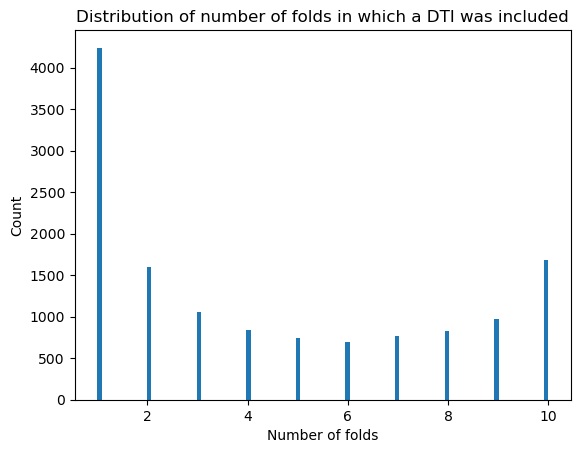

In [14]:
plt.figure() 
plt.hist(preds2.in_n_folds, bins=100)
plt.xlabel('Number of folds')
plt.ylabel('Count')
plt.title('Distribution of number of folds in which a DTI was included')
plt.show()

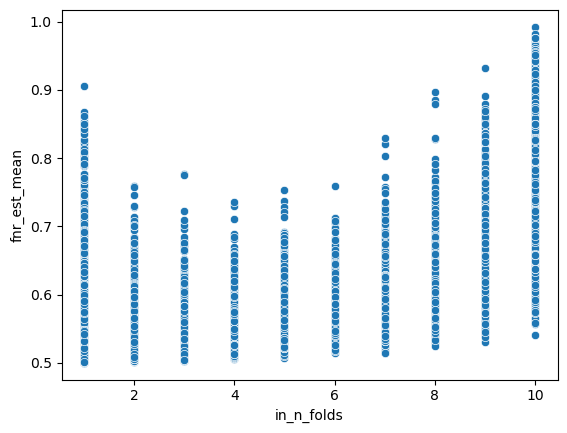

In [15]:
plt.figure()
sbn.scatterplot(y='fnr_est_mean', x='in_n_folds', data=preds2)
plt.show()

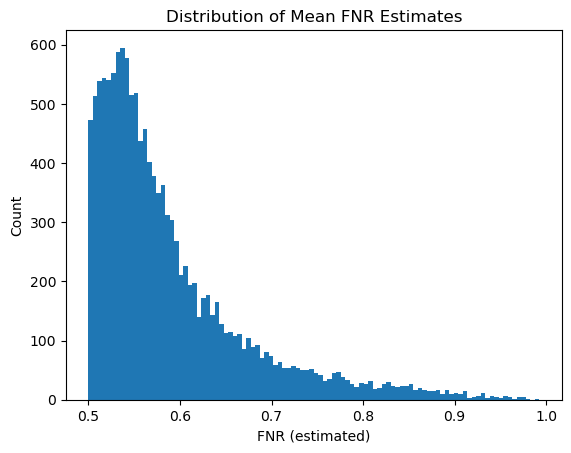

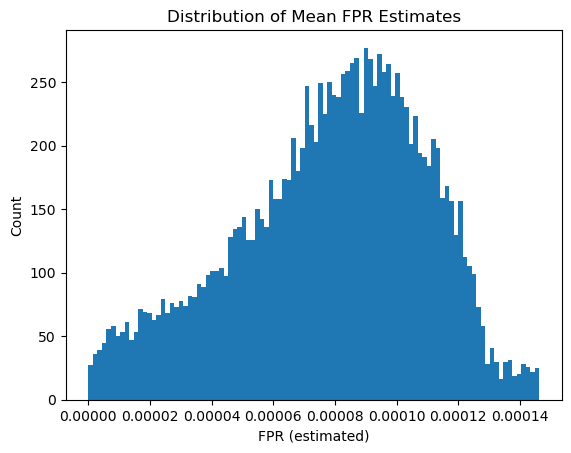

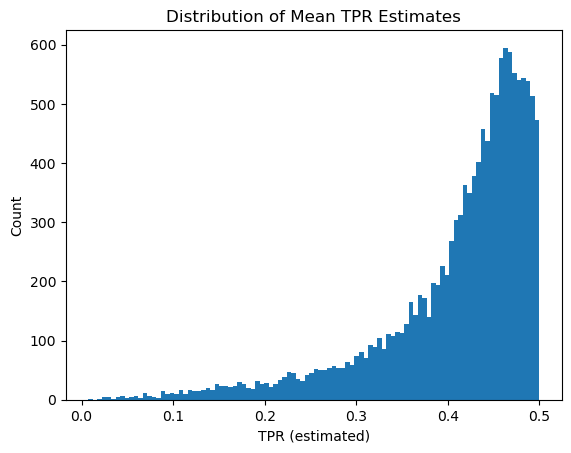

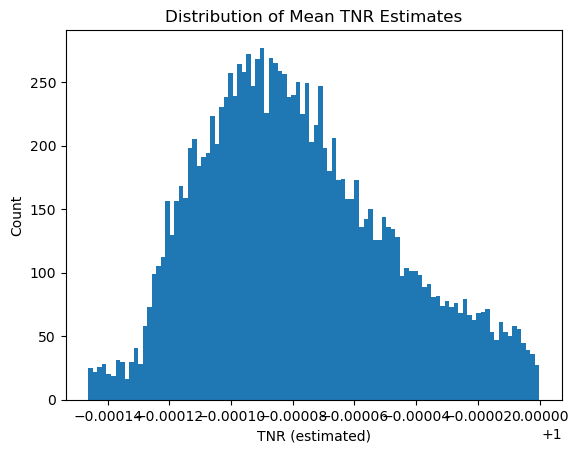

In [16]:
plt.figure() 
plt.hist(preds2.fnr_est_mean, bins=100)
plt.xlabel('FNR (estimated)')
plt.ylabel('Count')
plt.title('Distribution of Mean FNR Estimates')
plt.show() 

plt.figure() 
plt.hist(preds2.fpr_est_mean, bins=100)
plt.xlabel('FPR (estimated)')
plt.ylabel('Count')
plt.title('Distribution of Mean FPR Estimates')
plt.show() 

plt.figure() 
plt.hist(preds2.tpr_est_mean, bins=100)
plt.xlabel('TPR (estimated)')
plt.ylabel('Count')
plt.title('Distribution of Mean TPR Estimates')
plt.show()

plt.figure() 
plt.hist(preds2.tnr_est_mean, bins=100)
plt.xlabel('TNR (estimated)')
plt.ylabel('Count')
plt.title('Distribution of Mean TNR Estimates')
plt.show()




In [17]:
preds2[['inhibitor', 'gene_symbol', 'uniprot_id', 'fnr_est_mean', 'in_n_folds']].sort_values('fnr_est_mean', ascending=False).head(100).style.hide()

inhibitor,gene_symbol,uniprot_id,fnr_est_mean,in_n_folds
Alvocidib,CLK1,P49759,0.992502,10
R-406,MAP4K1,Q92918,0.981329,10
Penfluridol,ADRA1A,P35348,0.977590,10
Midostaurin,ROCK1,Q13464,0.976725,10
Kw-2449,STK3,Q13188,0.976508,10
R-406,MAP4K5,Q9Y4K4,0.976111,10
Tozasertib,KDR,P35968,0.972478,10
Midostaurin,ROCK2,O75116,0.971807,10
Tozasertib,CSF1R,P07333,0.969963,10
Crizotinib,FRK,P42685,0.969605,10


In [88]:
preds0 = read_preds(root, fold=0) 
preds0 = preds0[lambda x: x.negatives] 

In [89]:
inchi2idx = {v: int(i) for i, v in enumerate(data.node_name_dict['drug'])}
gene2idx = {v: int(i) for i, v in enumerate(data.node_name_dict['gene'])}

In [90]:
# https://www.probes-drugs.org/download
dap_targs = pd.read_csv('/mnt/c/Users/natha/Downloads/pd_export_02_2025_targets_standardized.csv')
dap_drugs = pd.read_csv('/mnt/c/Users/natha/Downloads/pd_export_02_2025_compounds_standardized.csv')
dap = dap_drugs[['pdid', 'inchikey']].merge(dap_targs[['pdid',  'gene_name', 'human_uniprot_id', 'activity_biochemical']], on='pdid', how='left').drop_duplicates()
dap = dap.groupby(['inchikey', 'pdid', 'human_uniprot_id', 'gene_name']).agg({'activity_biochemical': 'mean'}).reset_index()

/tmp/ipykernel_24930/1740964745.py:2: DtypeWarning: Columns (6,8,34) have mixed types. Specify dtype option on import or set low_memory=False.
  dap_targs = pd.read_csv('/mnt/c/Users/natha/Downloads/pd_export_02_2025_targets_standardized.csv')


In [91]:
dap2 = dap.assign(drug = dap.inchikey.map(inchi2idx), 
                 protein = dap.gene_name.map(gene2idx))

dap2 = dap2[lambda x: x.drug.notna() & x.protein.notna()]
dap2.drug = dap2.drug.astype(int)
dap2.protein = dap2.protein.astype(int)
dap2 = dap2.assign(inhibitor = dap2.inchikey.map(inchi2name.set_index('inchikey')['inhibitor']))
dap2.head() 


,inchikey,pdid,human_uniprot_id,gene_name,activity_biochemical,drug,protein,inhibitor
22,AAAQFGUYHFJNHI-SFHVURJKSA-N,PD003552,A6NHR9,SMCHD1,5.92,0,13925,Molibresib
24,AAAQFGUYHFJNHI-SFHVURJKSA-N,PD003552,O00170,AIP,5.00,0,480,Molibresib
25,AAAQFGUYHFJNHI-SFHVURJKSA-N,PD003552,O00203,AP3B1,7.20,0,737,Molibresib
26,AAAQFGUYHFJNHI-SFHVURJKSA-N,PD003552,O00231,PSMD11,7.22,0,11918,Molibresib
27,AAAQFGUYHFJNHI-SFHVURJKSA-N,PD003552,O00311,CDC7,7.06,0,2187,Molibresib


In [92]:
dap2[lambda x: (x.inhibitor.str.contains("Alvocidib")) & (x.gene_name == 'CLK1')]

,inchikey,pdid,human_uniprot_id,gene_name,activity_biochemical,drug,protein,inhibitor
13404,BIIVYFLTOXDAOV-YVEFUNNKSA-N,PD008756,P49759,CLK1,5.77,165,2731,Alvocidib


In [93]:
preds0_2 = preds0[['drug', 'protein', 'score']].merge(dap2[['drug', 'protein', 'activity_biochemical']], on=['drug', 'protein'], how='inner') 
preds0_2 = preds0_2[preds0_2.activity_biochemical.notna()]
preds0_2 = preds0_2.assign(inchikey = data.node_name_dict['drug'][preds0_2.drug])
preds0_2 = preds0_2.assign(gene_symbol = data.node_name_dict['gene'][preds0_2.protein]) 
preds0_2 = preds0_2.merge(inchi2name, on='inchikey', how='left') 
preds0_2 = preds0_2.merge(gene2uniprot, on='gene_symbol', how='left') 
preds0_2.head() 

,drug,protein,score,activity_biochemical,inchikey,gene_symbol,inhibitor,uniprot_id
0,0,145,-18.281683,7.67,AAAQFGUYHFJNHI-SFHVURJKSA-N,ACIN1,Molibresib,NaN
1,0,200,-20.427767,5.19,AAAQFGUYHFJNHI-SFHVURJKSA-N,ACTB,Molibresib,NaN
2,0,206,-21.453220,6.89,AAAQFGUYHFJNHI-SFHVURJKSA-N,ACTL6A,Molibresib,NaN
3,0,214,-19.799260,6.28,AAAQFGUYHFJNHI-SFHVURJKSA-N,ACTN4,Molibresib,NaN
4,0,224,-22.483717,7.06,AAAQFGUYHFJNHI-SFHVURJKSA-N,ACTR5,Molibresib,NaN


In [94]:
preds0_2[lambda x: x.inhibitor.str.contains("Alvocidib") & (x.gene_symbol == 'CLK1')]

,drug,protein,score,activity_biochemical,inchikey,gene_symbol,inhibitor,uniprot_id
1616,165,2731,-9.247083,5.77,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CLK1,Alvocidib,P49759


In [95]:
dap2.activity_biochemical.quantile(0.5)

np.float64(5.83)

In [96]:
preds0_2.shape

(21452, 8)

In [97]:
preds0_2[['activity_biochemical', 'score']].corr(method='spearman')

,activity_biochemical,score
activity_biochemical,1.000000,0.294748
score,0.294748,1.000000


In [98]:
preds0_2.activity_biochemical.isna().sum()

np.int64(0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     833.5
Date:                Tue, 30 Dec 2025   Prob (F-statistic):          7.70e-180
Time:                        11:34:44   Log-Likelihood:                -27744.
No. Observations:               21452   AIC:                         5.549e+04
Df Residuals:                   21450   BIC:                         5.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0501      0.002     28.870      0.0

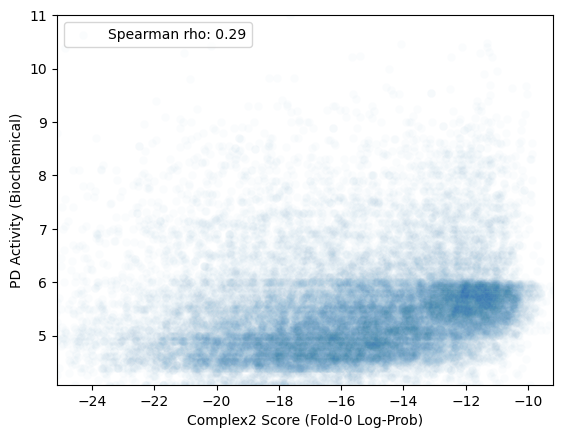

In [99]:
import statsmodels.api as sm 
from scipy.stats import spearmanr

preds0_2 = preds0_2.assign(bias = np.ones(preds0_2.shape[0]))
res = sm.OLS(preds0_2.activity_biochemical.values, preds0_2[['score', 'bias']].values).fit()
print(res.summary())

rho, pval = spearmanr(preds0_2.score, preds0_2.activity_biochemical)
print(f'Spearman rho: {rho:.2f}, p-value: {pval:.2e}')

xx = np.linspace(preds0_2.score.quantile(0.01), preds0_2.score.quantile(0.99), 100)
yy = res.params[0]*xx + res.params[1] 

plt.figure() 
sbn.scatterplot(x='score', y='activity_biochemical', data=preds0_2, alpha=0.02, label=f'Spearman rho: {rho:.2f}', linewidth=0)
#plt.plot(xx, yy, color='red')
plt.xlabel('Complex2 Score (Fold-0 Log-Prob)')
plt.ylabel('PD Activity (Biochemical)')
plt.xlim(preds0_2.score.quantile(0.01), preds0_2.score.quantile(1))
plt.ylim(preds0_2.activity_biochemical.quantile(0.01), preds0_2.activity_biochemical.quantile(1))
plt.show() 






In [ ]:
# TODO: compare this to jglaser - how much overlap? 
# No jglaser for targetome, explicitly removed during training

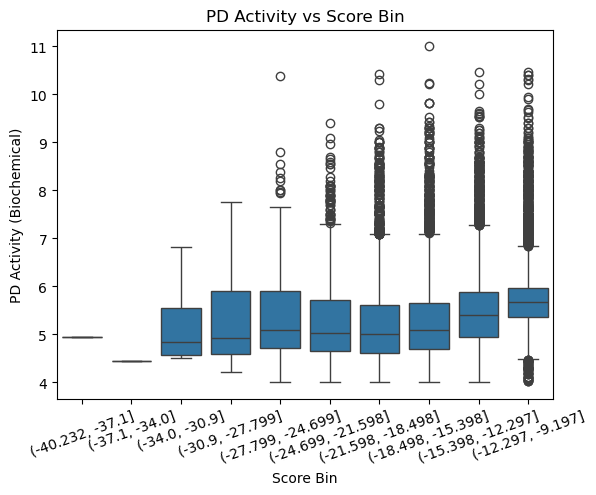

In [100]:
preds0_2 = preds0_2.assign(score_binned = pd.cut(preds0_2.score, bins=10)) 

plt.figure() 
sbn.boxplot(x='score_binned', y='activity_biochemical', data=preds0_2) 
plt.xticks(rotation=20)
plt.xlabel('Score Bin')
plt.ylabel('PD Activity (Biochemical)')
plt.title('PD Activity vs Score Bin')
plt.show() 






In [101]:
targetome = pd.read_csv('~/local/data/targetome_extended-01-23-25.csv')
targetome.head() 


,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value
0,6,VYZAHLCBVHPDDF-UHFFFAOYSA-N,P78417,29652143.0,pubchem_bioassay,IC50,=,900000.0
1,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P0DMS8,19282184.0,pubchem_bioassay,Ki,>,100000.0
2,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29274,19282184.0,pubchem_bioassay,Ki,=,2200.0
3,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29275,19282184.0,pubchem_bioassay,Ki,>,30000.0
4,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P30542,19282184.0,pubchem_bioassay,Ki,=,7400.0


In [102]:
preds0.head()

,drug,protein,score,train,valid,test,negatives,prob,uid,fold
0,0,0,-18.626640,False,False,False,True,0.689179,a899a0af-329f-4937-8906-61ad29be2b9e,0
1,0,1,-24.664598,False,False,False,True,0.499770,a899a0af-329f-4937-8906-61ad29be2b9e,0
2,0,2,-22.241549,False,False,False,True,0.575781,a899a0af-329f-4937-8906-61ad29be2b9e,0
3,0,3,-23.638212,False,False,False,True,0.531968,a899a0af-329f-4937-8906-61ad29be2b9e,0
4,0,4,-21.656570,False,False,False,True,0.594131,a899a0af-329f-4937-8906-61ad29be2b9e,0


In [110]:
uni2gene = gene2uniprot.set_index('uniprot_id').to_dict()['gene_symbol']

targetome = targetome[['inchi_key','uniprot_id', 'assay_type', 'assay_relation', 'assay_value']].drop_duplicates() 
targetome = targetome[lambda x: x.assay_relation == '=']
targetome = targetome.groupby(['inchi_key', 'uniprot_id']).agg({'assay_value': 'mean'}).reset_index()
targetome = targetome.assign(gene_symbol = targetome.uniprot_id.map(uni2gene))
targetome = targetome.assign(drug = targetome.inchi_key.map(inchi2idx))
targetome = targetome.assign(protein = targetome.gene_symbol.map(gene2idx))

preds0_3 = preds0.merge(targetome, on=['drug', 'protein'], how='inner')
preds0_3.head() 

,drug,protein,score,train,valid,test,negatives,prob,uid,fold,inchi_key,uniprot_id,assay_value,gene_symbol
0,0,4316,-16.410612,False,False,False,True,0.758695,a899a0af-329f-4937-8906-61ad29be2b9e,0,AAAQFGUYHFJNHI-SFHVURJKSA-N,Q09472,71000.0,EP300
1,3,24,-13.470697,False,False,False,True,0.850920,a899a0af-329f-4937-8906-61ad29be2b9e,0,AAKJLRGGTJKAMG-UHFFFAOYSA-N,Q2M2I8,2800.0,AAK1
2,3,47,-11.666540,False,False,False,True,0.907516,a899a0af-329f-4937-8906-61ad29be2b9e,0,AAKJLRGGTJKAMG-UHFFFAOYSA-N,P08183,26000.0,ABCB1
3,3,569,-12.858437,False,False,False,True,0.870126,a899a0af-329f-4937-8906-61ad29be2b9e,0,AAKJLRGGTJKAMG-UHFFFAOYSA-N,Q9UM73,1200.0,ALK
4,3,1220,-12.228890,False,False,False,True,0.889875,a899a0af-329f-4937-8906-61ad29be2b9e,0,AAKJLRGGTJKAMG-UHFFFAOYSA-N,O14965,3000.0,AURKA


In [111]:
preds0_3[['score', 'assay_value']].corr(method='spearman') 

,score,assay_value
score,1.000000,-0.410759
assay_value,-0.410759,1.000000


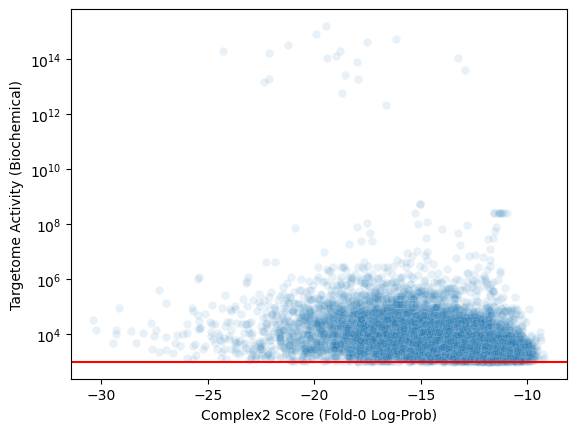

In [ ]:
plt.figure() 
sbn.scatterplot(x='score', y='assay_value', data=preds0_3, alpha=0.1) 
plt.xlabel('Complex2 Score (Fold-0 Log-Prob)')
plt.ylabel('Targetome Activity (Biochemical)')
plt.yscale('log')
plt.axhline(1000, color='red')
plt.show() 

In [ ]:
preds0_3

(9282, 14)

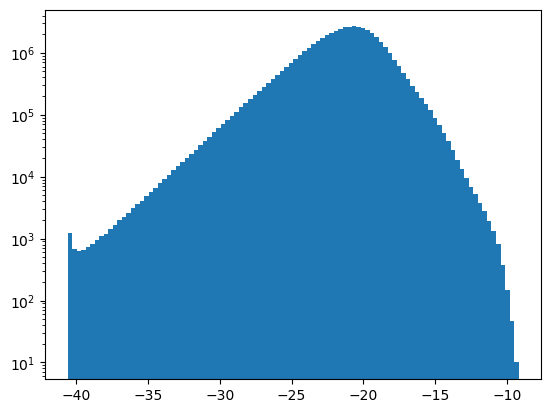

In [115]:
plt.figure() 
plt.hist(preds0.score, bins=100) 
plt.yscale('log')
plt.show()